In [1]:
### PREREQUISTIES
### (many used only in one notebook...)

# common python libraries
import os
import pandas as pd
import numpy as np
import logging ### to monitor the code
from bs4 import BeautifulSoup
import pickle
import math
import random
import sys
import csv
import unicodedata
import requests
import re

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from scipy import stats

# data exchange with googlesheets
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

# data exchange with sciencedata
import sddk

# language data modeling with gensim
from gensim import corpora
from gensim import models

# language data modeling with sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD  
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
### not neccessary for reading the data, just for exporting data and especially plots to sciencedata.dk
conf = sddk.configure()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [3]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
PIA_data = gc.open_by_url("https://docs.google.com/spreadsheets/d/1KxOx7Be9fj3lDcEPgQhQ-Iqcn9p367-MMD6RMXe8rks/edit?usp=sharing")
PIA_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1e94wyelg6dftQ4zxbq1xvwxWAI-BhcYXtclDW-YTnrw/edit?usp=sharing")

# Import corpus

In [4]:
# import preprocessed data corpora from a public folder on sciencedata
publicfolder = "31b393e2afe1ee96ce81869c7efe18cb"
c_hippocraticum = sddk.read_file("c_hippocraticum_enriched.json", "df", publicfolder)

reading file located in a public folder


In [154]:
def get_flat_sentences(series):
    sentences_list = [sent for doc in series.tolist() for sent in doc]
    return sentences_list

In [155]:
# docs = sentences
docs = get_flat_sentences(c_hippocraticum["lemmatized_sentences_repl"])

In [902]:
len(docs)

24456

In [904]:
morpheus_by_lemma["ἄλγημα"]

[{'d': 1341, 'l': 'ἄλγημα', 's': 'pain, suffering', 'a': None}]

In [156]:
print(docs[:10])

[['ὁπόσος', 'ἐπιχειρέω', 'ἰητρικῆς', 'λέγω', 'γράφω', 'ὑπόθεσις', 'αὐτός', 'ὑποθέμενοι', 'λόγος', 'θερμός', 'ψυχρός', 'ὑγρός', 'ξηρός', 'ἄλλος', 'ἐθέλω', 'βραχύς', 'ἄγω', 'ἀρχή', 'αἰτία', 'ἄνθρωπος', 'νοῦσος', 'θάνατος', 'πᾶς', 'αὐτός', 'εἷς', 'ὑποθέμενοι', 'πολύς', 'λέγω', 'καταφανής', 'εἰμί', 'ἁμαρτάνω', 'ἄξιος', 'μέμφομαι', 'τέχνη', 'εἰμί', 'χράω', 'πᾶς', 'μέγας', 'τιμάω', 'ἀγαθός', 'χειροτέχνης', 'δημιουργός'], ['δημιουργός', 'φαῦλος', 'πολύς', 'διαφέροντες'], ['εἰμί', 'ἰατρικός', 'αὐτός', 'ἔσκεπτο', 'εὑρίσκω', 'μηδείς', 'εἰμί', 'πᾶς', 'ἄπειρος', 'ἀνεπιστήμων', 'εἰμί', 'τύχη', 'κάμνω', 'διοικεῖτο'], ['ἔχω', 'ἄλλος', 'τέχνη', 'δημιουργός', 'πολύς', 'διαφέρω', 'χείρ', 'γνώμη', 'ἰητρικῆς'], ['ἀξιόω', 'κενός', 'ὑπόθεσις', 'δέω', 'ἀφανέα', 'ἀπορεόμενα', 'ἀνάγκη', 'ἐπιχειρέω', 'λέγω', 'ὑπόθεσις', 'χράω', 'οἷος', 'μετέωρος', 'γῆ'], ['τὶς', 'λέγω', 'γιγνώσκω', 'ἔχω', 'λέγω', 'ἀκούω', 'δῆλος', 'εἰμί', 'ἀληθής', 'εἰμί'], ['χρή', 'ἀνενέγκαντα', 'οἶδα', 'σαφής'], ['ἰατρικός', 'πᾶς', 'ὑπάρχω', 

In [157]:
c_hippocraticum["wordcount"].sum()

333443

In [158]:
c_hippocraticum["lemmata_repl"].apply(lambda x: len(x)).sum()

171332

In [159]:
# perhaps we will also explore our subcorpora at some point
subcorpora = {}
for cat in c_hippocraticum["work_cat_linka"].unique():
    subcorpora[cat] = get_flat_sentences(c_hippocraticum[c_hippocraticum["work_cat_linka"]==cat]["lemmatized_sentences_repl"])

for key in subcorpora.keys():
    print(key, len(subcorpora[key]))

Theoretical 2501
Other 16911
Practical 5044


In [507]:
#create gensim dictionary for our list of sentences
dictionary_sents = corpora.Dictionary(docs)

there is a number of methods to be applied upon a dictionary object:
see: https://radimrehurek.com/gensim/corpora/dictionary.html

First of all, you can inspect it as a standard dictionary object


In [161]:
# uncomment below to print the whole dictionary
# dictionary

In [508]:
# as such, it is organized by ids
dict(list(dictionary_sents.items())[:10])

{0: 'αἰτία',
 1: 'αὐτός',
 2: 'βραχύς',
 3: 'γράφω',
 4: 'δημιουργός',
 5: 'εἰμί',
 6: 'εἷς',
 7: 'θάνατος',
 8: 'θερμός',
 9: 'καταφανής'}

In [509]:
# but you can access it reveresly by applying token2id method
dict(list(dictionary_sents.token2id.items())[:10])

{'αἰτία': 0,
 'αὐτός': 1,
 'βραχύς': 2,
 'γράφω': 3,
 'δημιουργός': 4,
 'εἰμί': 5,
 'εἷς': 6,
 'θάνατος': 7,
 'θερμός': 8,
 'καταφανής': 9}

In [510]:
# collection_frequencies
dictionary_sents.cfs[7] # how many instances of word with id 7 (= "θάνατος")

81

In [511]:
dictionary_sents.dfs[7] # how many documents contain the word with id 7 (= "θάνατος")

81

In [512]:
dictionary_sents.num_pos # previously 167358

171332

In [513]:
len(dictionary_sents.keys())

25275

In [168]:
sent = docs[20]
sent

['ἀνάγκη',
 'ἰατρικός',
 'ποιέω',
 'ζητέω',
 'εὑρίσκω',
 'ἄνθρωπος',
 'κάμνω',
 'ταὐτός',
 'προσφερομένοισι',
 'ὑγιαίνοντες',
 'συμφέρω',
 'συμφέρω']

In [514]:
# doc2bow = document to (term, tf) tuples, i.e. bag-of-words
dictionary_sents.doc2bow(sent)

[(28, 1),
 (40, 1),
 (41, 1),
 (47, 1),
 (57, 1),
 (72, 1),
 (118, 1),
 (119, 2),
 (122, 1),
 (123, 1),
 (124, 1)]

In [515]:
# we can use our gensim dictionary

# as a corpus, we cannot use the Gensim default BoW model,

# we just need the words replaced by values

corpus_bow = [dictionary_sents.doc2bow(sent) for sent in docs]
corpus_idx = [dictionary_sents.doc2idx(sent) for sent in docs]

# LSA with  sklearn

In [1200]:
# build gensim dictionary on the basis of whole works
lemmata = c_hippocraticum["lemmata_repl"].tolist()
dictionary = corpora.Dictionary(lemmata)
# words in at least 2 works
# with the number of sentences in which they appear
dictionary_tup = [(len([doc for doc in docs if dictionary[word_id] in doc]), dictionary[word_id]) for word_id in dictionary if dictionary.dfs[word_id] >= 5]
#n=2000 # n sorted words with highest frequency
vocabulary = [tup[1] for tup in sorted(dictionary_tup, reverse=True)] #[:n]]
doc_freq = [tup[0] for tup in sorted(dictionary_tup, reverse=True)] #[:n]]

In [1201]:
len(vocabulary)

2032

In [1202]:
sorted(dictionary_tup, reverse=True)[:10]

[(3315, 'εἰμί'),
 (2829, 'γίγνομαι'),
 (2351, 'οὗτος'),
 (2103, 'πολύς'),
 (1775, 'ἔχω'),
 (1224, 'ἄλλος'),
 (1169, 'σῶμα'),
 (1129, 'ποιέω'),
 (1030, 'χρή'),
 (1010, 'αὐτός')]

In [1203]:
len(vocabulary)

2032

In [1204]:
for word in key_words:
    if word in vocabulary:
        print(word)

πόνο*
ὀδύν*
ἄλγ*
λύπ*


In [1205]:
vocabulary[:10]

['εἰμί',
 'γίγνομαι',
 'οὗτος',
 'πολύς',
 'ἔχω',
 'ἄλλος',
 'σῶμα',
 'ποιέω',
 'χρή',
 'αὐτός']

In [1206]:
docs[0]

['ὁπόσος',
 'ἐπιχειρέω',
 'ἰητρικῆς',
 'λέγω',
 'γράφω',
 'ὑπόθεσις',
 'αὐτός',
 'ὑποθέμενοι',
 'λόγος',
 'θερμός',
 'ψυχρός',
 'ὑγρός',
 'ξηρός',
 'ἄλλος',
 'ἐθέλω',
 'βραχύς',
 'ἄγω',
 'ἀρχή',
 'αἰτία',
 'ἄνθρωπος',
 'νοῦσος',
 'θάνατος',
 'πᾶς',
 'αὐτός',
 'εἷς',
 'ὑποθέμενοι',
 'πολύς',
 'λέγω',
 'καταφανής',
 'εἰμί',
 'ἁμαρτάνω',
 'ἄξιος',
 'μέμφομαι',
 'τέχνη',
 'εἰμί',
 'χράω',
 'πᾶς',
 'μέγας',
 'τιμάω',
 'ἀγαθός',
 'χειροτέχνης',
 'δημιουργός']

In [1207]:
# SIMPLE TEST
# (by default, countvectorizers does some undesirable preprocessing (e.g. removes *....))
test_corpus =  [['δῆμος*', 'Ἀθηναῖος','φαίνω','Ἕλλην'], ['δοκέω','οὗτος','τέχνη','ἐμός']]
vec_bow = CountVectorizer(lowercase=False, token_pattern=r"\w+\*?") #vocabulary=vocabulary, token_pattern=r".?\w+\*?") #, #strip_accents=None, encoding="utf-8") #, token_pattern=r"\*?\w+\*?")
bow = vec_bow.fit_transform([" ".join(sentence) for sentence in test_corpus]) ### run the model
vec_bow.get_feature_names()

['δοκέω', 'δῆμος*', 'οὗτος', 'τέχνη', 'φαίνω', 'Ἀθηναῖος', 'ἐμός', 'Ἕλλην']

In [1208]:
vec_bow = CountVectorizer(lowercase=False, token_pattern=r"\w+\*?") #vocabulary=vocabulary, token_pattern=r".?\w+\*?") #, #strip_accents=None, encoding="utf-8") #, token_pattern=r"\*?\w+\*?")
bow = vec_bow.fit_transform([" ".join(sentence) for sentence in test_corpus]) ### run the model
#cooc  = bow.T * bow
#cooc_df = pd.DataFrame(cooc.todense(), columns=vec_bow.featurenames(), index=vec_bow.feature_names()) # / len(docs
vec_bow.get_feature_names()

['δοκέω', 'δῆμος*', 'οὗτος', 'τέχνη', 'φαίνω', 'Ἀθηναῖος', 'ἐμός', 'Ἕλλην']

In [1209]:
vec_tfidf = TfidfVectorizer(vocabulary=vocabulary, lowercase=False, token_pattern=r"\w+\*?") ### initiaze the model
vec_bow = CountVectorizer(vocabulary=vocabulary, lowercase=False, token_pattern=r"\w+\*?") #vocabulary=vocabulary, token_pattern=r".?\w+\*?") #, #strip_accents=None, encoding="utf-8") #, token_pattern=r"\*?\w+\*?")

tfidf = vec_tfidf.fit_transform([" ".join(sentence) for sentence in docs]) ### run the model
bow = vec_bow.fit_transform([" ".join(sentence) for sentence in docs]) ### run the model

cooc  = bow.T * bow
cooc.setdiag(doc_freq) # word-word coocurrence matrix
cooc_df = pd.DataFrame(cooc.todense() / len(docs), columns=vocabulary, index=vocabulary) # / len(docs)
cooc_df

/home/kasev/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.



,εἰμί,γίγνομαι,οὗτος,πολύς,ἔχω,ἄλλος,σῶμα,ποιέω,χρή,αὐτός,...,κωφός,κλίνω,καταπαύω,καταπίπτω,θόρυβος,εὐεξίη,διηγέομαι,διαῤῥοίῃ,διαχωρέῃ,βῆχας
εἰμί,0.135550,0.025515,0.022571,0.023266,0.018768,0.014230,0.014475,0.008505,0.010345,0.012512,...,0.000082,0.000041,0.000000,0.000204,0.000000,0.000164,0.000082,0.000000,0.000082,0.000041
γίγνομαι,0.025515,0.115677,0.020077,0.022448,0.012226,0.009773,0.013739,0.005275,0.003721,0.009446,...,0.000082,0.000041,0.000082,0.000000,0.000041,0.000000,0.000082,0.000041,0.000041,0.000123
οὗτος,0.022571,0.020077,0.096132,0.013494,0.010672,0.007565,0.005357,0.008301,0.005561,0.004702,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000041,0.000000,0.000000,0.000000,0.000041
πολύς,0.023266,0.022448,0.013494,0.085991,0.012512,0.009486,0.009650,0.006133,0.005357,0.005561,...,0.000000,0.000000,0.000041,0.000000,0.000000,0.000041,0.000041,0.000000,0.000082,0.000041
ἔχω,0.018768,0.012226,0.010672,0.012512,0.072579,0.008178,0.008137,0.004130,0.006093,0.005520,...,0.000000,0.000082,0.000000,0.000041,0.000000,0.000041,0.000041,0.000041,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
εὐεξίη,0.000164,0.000000,0.000041,0.000041,0.000041,0.000041,0.000123,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000204,0.000000,0.000000,0.000000,0.000000
διηγέομαι,0.000082,0.000082,0.000000,0.000041,0.000041,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000204,0.000000,0.000000,0.000000
διαῤῥοίῃ,0.000000,0.000041,0.000000,0.000000,0.000041,0.000041,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000204,0.000000,0.000000
διαχωρέῃ,0.000082,0.000041,0.000000,0.000082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000204,0.000000


In [1210]:
pmi_rows_list = []
for column in cooc_df.columns:
    freq_a = cooc_df.at[column, column]
    pmi_row = []
    for term in cooc_df.index:
        freq_ab = cooc_df.at[column, term]
        if freq_ab > 0:
            freq_ab = freq_ab **3
            freq_b = cooc_df.at[term, term]
            pmi2 = math.log(freq_ab / (freq_a * freq_b))
        else:
            pmi2 = None
        pmi_row.append(pmi2)
    pmi_rows_list.append(pmi_row)

In [1211]:
pmi_matrix = pd.DataFrame(pmi_rows_list, columns=vocabulary, index=vocabulary)

In [1212]:
pmi_matrix_df = pd.DataFrame(pmi_matrix)
pmi_matrix_df

,εἰμί,γίγνομαι,οὗτος,πολύς,ἔχω,ἄλλος,σῶμα,ποιέω,χρή,αὐτός,...,κωφός,κλίνω,καταπαύω,καταπίπτω,θόρυβος,εὐεξίη,διηγέομαι,διαῤῥοίῃ,διαχωρέῃ,βῆχας
εἰμί,-1.998418,-6.850071,-7.032796,-6.830323,-7.305249,-7.764116,-7.666857,-9.227317,-8.547989,-7.957794,...,-17.740840,-19.820282,NaN,-14.991968,NaN,-15.661399,-17.740840,NaN,-17.740840,-19.820282
γίγνομαι,-6.850071,-2.156952,-7.225573,-6.779134,-8.432534,-8.732798,-7.664880,-10.501960,-11.457045,-8.642762,...,-17.582306,-19.661747,-17.582306,NaN,-19.661747,NaN,-17.582306,-19.661747,-19.661747,-16.365910
οὗτος,-7.032796,-7.225573,-2.342035,-8.121069,-8.655221,-9.316039,-10.305539,-8.956697,-10.066576,-10.550136,...,NaN,NaN,NaN,NaN,NaN,-19.476665,NaN,NaN,NaN,-19.476665
πολύς,-6.830323,-6.779134,-8.121069,-2.453511,-8.066551,-8.525418,-8.428160,-9.752933,-10.067473,-9.935492,...,NaN,NaN,-19.365189,NaN,NaN,-19.365189,-19.365189,NaN,-17.285747,-19.365189
ἔχω,-7.305249,-8.432534,-8.655221,-8.066551,-2.623075,-8.801114,-8.770176,-10.769913,-9.511662,-9.788068,...,NaN,-17.116183,NaN,-19.195624,NaN,-19.195624,-19.195624,-19.195624,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
εὐεξίη,-15.661399,NaN,-19.476665,-19.365189,-19.195624,-18.823948,-15.482136,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-8.495193,NaN,NaN,NaN,NaN
διηγέομαι,-17.740840,-17.582306,NaN,-19.365189,-19.195624,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-8.495193,NaN,NaN,NaN
διαῤῥοίῃ,NaN,-19.661747,NaN,NaN,-19.195624,-18.823948,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.495193,NaN,NaN
διαχωρέῃ,-17.740840,-19.661747,NaN,-17.285747,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.495193,NaN


our data are results of an algorithm to values lower than 1, what basicially implies negative numbers (see image below). Since this is not so well readible and interpretable, we will normalize these data to the scale from 


![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Binary_logarithm_plot_with_ticks.svg/600px-Binary_logarithm_plot_with_ticks.svg.png)

In [1213]:
minval, maxval = pmi_matrix_df.min().min(), pmi_matrix_df.max().max()
print(minval, maxval)

-23.404167568348303 -1.9984179609507073


In [1214]:
minval_2 = minval * 2
minval_2

-46.808335136696606

In [1215]:
0.1 / 0.2

0.5

In [1216]:
(0.1 **3) / (0.2 **3) 

0.125

In [1217]:
0.2 **2 

0.04000000000000001

In [1218]:
pmi_matrix_df.fillna(minval_2, inplace=True)
pmi_matrix_df

,εἰμί,γίγνομαι,οὗτος,πολύς,ἔχω,ἄλλος,σῶμα,ποιέω,χρή,αὐτός,...,κωφός,κλίνω,καταπαύω,καταπίπτω,θόρυβος,εὐεξίη,διηγέομαι,διαῤῥοίῃ,διαχωρέῃ,βῆχας
εἰμί,-1.998418,-6.850071,-7.032796,-6.830323,-7.305249,-7.764116,-7.666857,-9.227317,-8.547989,-7.957794,...,-17.740840,-19.820282,-46.808335,-14.991968,-46.808335,-15.661399,-17.740840,-46.808335,-17.740840,-19.820282
γίγνομαι,-6.850071,-2.156952,-7.225573,-6.779134,-8.432534,-8.732798,-7.664880,-10.501960,-11.457045,-8.642762,...,-17.582306,-19.661747,-17.582306,-46.808335,-19.661747,-46.808335,-17.582306,-19.661747,-19.661747,-16.365910
οὗτος,-7.032796,-7.225573,-2.342035,-8.121069,-8.655221,-9.316039,-10.305539,-8.956697,-10.066576,-10.550136,...,-46.808335,-46.808335,-46.808335,-46.808335,-46.808335,-19.476665,-46.808335,-46.808335,-46.808335,-19.476665
πολύς,-6.830323,-6.779134,-8.121069,-2.453511,-8.066551,-8.525418,-8.428160,-9.752933,-10.067473,-9.935492,...,-46.808335,-46.808335,-19.365189,-46.808335,-46.808335,-19.365189,-19.365189,-46.808335,-17.285747,-19.365189
ἔχω,-7.305249,-8.432534,-8.655221,-8.066551,-2.623075,-8.801114,-8.770176,-10.769913,-9.511662,-9.788068,...,-46.808335,-17.116183,-46.808335,-19.195624,-46.808335,-19.195624,-19.195624,-19.195624,-46.808335,-46.808335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
εὐεξίη,-15.661399,-46.808335,-19.476665,-19.365189,-19.195624,-18.823948,-15.482136,-46.808335,-46.808335,-46.808335,...,-46.808335,-46.808335,-46.808335,-46.808335,-46.808335,-8.495193,-46.808335,-46.808335,-46.808335,-46.808335
διηγέομαι,-17.740840,-17.582306,-46.808335,-19.365189,-19.195624,-46.808335,-46.808335,-46.808335,-46.808335,-46.808335,...,-46.808335,-46.808335,-46.808335,-46.808335,-46.808335,-46.808335,-8.495193,-46.808335,-46.808335,-46.808335
διαῤῥοίῃ,-46.808335,-19.661747,-46.808335,-46.808335,-19.195624,-18.823948,-46.808335,-46.808335,-46.808335,-46.808335,...,-46.808335,-46.808335,-46.808335,-46.808335,-46.808335,-46.808335,-46.808335,-8.495193,-46.808335,-46.808335
διαχωρέῃ,-17.740840,-19.661747,-46.808335,-17.285747,-46.808335,-46.808335,-46.808335,-46.808335,-46.808335,-46.808335,...,-46.808335,-46.808335,-46.808335,-46.808335,-46.808335,-46.808335,-46.808335,-46.808335,-8.495193,-46.808335


In [1219]:
pmi_matrix_norm_df = (pmi_matrix_df - minval_2) / (maxval - minval_2)
pmi_matrix_norm_df

,εἰμί,γίγνομαι,οὗτος,πολύς,ἔχω,ἄλλος,σῶμα,ποιέω,χρή,αὐτός,...,κωφός,κλίνω,καταπαύω,καταπίπτω,θόρυβος,εὐεξίη,διηγέομαι,διαῤῥοίῃ,διαχωρέῃ,βῆχας
εἰμί,1.000000,0.891728,0.887650,0.892169,0.881570,0.871330,0.873500,0.838676,0.853837,0.867008,...,0.648684,0.602279,0.000000,0.710030,0.000000,0.695090,0.648684,0.000000,0.648684,0.602279
γίγνομαι,0.891728,0.996462,0.883348,0.893311,0.856413,0.849712,0.873544,0.810231,0.788917,0.851722,...,0.652222,0.605817,0.652222,0.000000,0.605817,0.000000,0.652222,0.605817,0.605817,0.679368
οὗτος,0.887650,0.883348,0.992332,0.863364,0.851444,0.836696,0.814614,0.844716,0.819947,0.809156,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.609947,0.000000,0.000000,0.000000,0.609947
πολύς,0.892169,0.893311,0.863364,0.989844,0.864581,0.854340,0.856511,0.826946,0.819927,0.822872,...,0.000000,0.000000,0.612435,0.000000,0.000000,0.612435,0.612435,0.000000,0.658840,0.612435
ἔχω,0.881570,0.856413,0.851444,0.864581,0.986060,0.848188,0.848878,0.804251,0.832331,0.826162,...,0.000000,0.662625,0.000000,0.616219,0.000000,0.616219,0.616219,0.616219,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
εὐεξίη,0.695090,0.000000,0.609947,0.612435,0.616219,0.624513,0.699091,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.855015,0.000000,0.000000,0.000000,0.000000
διηγέομαι,0.648684,0.652222,0.000000,0.612435,0.616219,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.855015,0.000000,0.000000,0.000000
διαῤῥοίῃ,0.000000,0.605817,0.000000,0.000000,0.616219,0.624513,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.855015,0.000000,0.000000
διαχωρέῃ,0.648684,0.605817,0.000000,0.658840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.855015,0.000000


In [1220]:
key_words = ['πόνο*', 'ὀδύν*', 'ἄλγ*', 'λύπ*']

In [1221]:
keyterms_pmi_20 = {}
for keyterm in key_words:
    keyterms_pmi_20[keyterm] = keyterm_pmi_20_words = pmi_matrix_norm_df.sort_values(keyterm, ascending=False).index[1:21].tolist()
    keyterms_pmi_20[keyterm + " PPMI3"] = pmi_matrix_norm_df.sort_values(keyterm, ascending=False)[keyterm].tolist()[1:21]
    #keyterms_pmi_20.extend([keyterm_pmi_20_words, keyterm_pmi_20_values])   #, ascending=False) # ["πόνο*"][:10]

In [1222]:
keyterms_pmi_20_df = pd.DataFrame(keyterms_pmi_20)
keyterms_pmi_20_df

,πόνο*,πόνο* PPMI3,ὀδύν*,ὀδύν* PPMI3,ἄλγ*,ἄλγ* PPMI3,λύπ*,λύπ* PPMI3
0,σῶμα,0.837290,ἔχω,0.867757,ὀσφῦς,0.837276,εἰμί,0.771058
1,γίγνομαι,0.832734,πυρετός,0.855526,κεφαλή,0.824884,προσήκω,0.764788
2,πολύς,0.828578,γίγνομαι,0.853098,πυρετός,0.821875,ἄνθρωπος,0.752255
3,εἰμί,0.811721,γαστήρ,0.849051,ὀδύν*,0.816113,συμβαίνω,0.742788
4,ἄλλος,0.806810,ἴσχω,0.848228,γαστήρ,0.805608,αὐτός,0.740855
5,πυρετός,0.804623,ἰξύς,0.847139,ἔχω,0.804246,σῶμα,0.737593
6,ἔχω,0.802781,κενεών,0.841744,εἰμί,0.793327,γίγνομαι,0.737130
7,κοιλία,0.801894,κεφαλή,0.840008,κοιλία,0.792522,οὐδείς,0.733965
8,χρόνος,0.796564,παρέχω,0.833942,γίγνομαι,0.791752,φυσᾶται,0.731851
9,σιτίον,0.794128,πολύς,0.828922,ἰξύς,0.791586,ἀλύω,0.728871


In [1223]:
pmi_words = []
for keyword in key_words:
    pmi_words.extend(keyterms_pmi_20_df[keyword].tolist())
pmi_words = list(set(pmi_words))
print(pmi_words)

['κρύπτω', 'οὗτος', 'μήτρα', 'ἄλγ*', 'πλευροῦ', 'ἰσχίον', 'αὐτός', 'ἰσχυρός', 'σῖτος', 'πυρετός', 'πλείων', 'χρόνος', 'ἄνθρωπος', 'πᾶς', 'ἐσθίω', 'ῥῖγος', 'κοιλία', 'σάρξ', 'οὐδείς', 'εἰμί', 'κεφαλή', 'ἡδονή', 'προσήκω', 'ἐξέρχομαι', 'ἄλλος', 'κενεών', 'σιτίον', 'βήξ', 'στῆθος', 'ὀσφῦς', 'συμβαίνω', 'ὀξείη', 'φοβερός', 'ἴσχω', 'φυσᾶται', 'ἀλύω', 'αἰσθάνομαι', 'ὀξύς', 'νῶτον', 'παύω', 'τράχηλος', 'πλευρόν', 'οἰδέουσι', 'γαστήρ', 'λαμβάνω', 'ὠχρός', 'γίγνομαι', 'σῶμα', 'παρέχω', 'πολύς', 'ἰξύς', 'ὀδύν*', 'ἔχω']


In [1257]:
# read manually coded colors
terms_by_cat_df = get_as_dataframe(PIA_overview.worksheet("terms_by_cat"))
terms_by_cat_dict = dict(zip(terms_by_cat_df["term"], terms_by_cat_df["term_category"]))

uncoded = [word for word in pmi_words if word not in terms_by_cat_dict.keys()]
print(uncoded)

[]


In [1258]:
uncoded_anot = []
for word in uncoded:
    try: uncoded_anot.append(morpheus_by_lemma[word])
    except: uncoded_anot.append(word)
uncoded_anot

[]

In [1259]:
term_cats = list(set(terms_by_cat_dict.values()))
print(term_cats)

['pathological state', 'quality', 'dietetic term', 'temporal quality', 'pain-word', 'general term', 'bodily part or constituent']


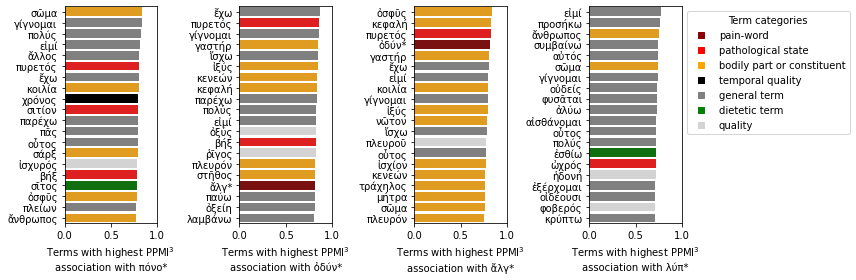

In [1261]:
# read manually coded colors
terms_by_cat_df = get_as_dataframe(PIA_overview.worksheet("terms_by_cat"))
terms_by_cat_dict = dict(zip(terms_by_cat_df["term"], terms_by_cat_df["term_category"]))

colors = ["darkred", "red", "orange", "black", "gray", "green","lightgray"]
term_cats = list(set(terms_by_cat_dict.values()))

cat_colors_dict = {'pain-word': 'darkred',
 'pathological state': 'red',
 'bodily part or constituent': 'orange',
 'temporal quality': 'black',
 'general term': 'gray',
 'dietetic term': 'green',
 'quality': 'lightgray'}
terms_by_col_dict = {}
for key in terms_by_cat_dict.keys():
    #print(key)
    terms_by_col_dict[key] = cat_colors_dict[terms_by_cat_dict[key]]
    
#plt.rcParams['figure.figsize'] = [12, 4]
fig, axs = plt.subplots(1, 4, figsize=[12,4], tight_layout=True)

for word, ax in zip(key_words, axs):
    xcol = keyterms_pmi_20_df[word + " PPMI3"]
    ycol = keyterms_pmi_20_df[word]
    actual_colors = [terms_by_col_dict[word] for word in ycol]
    sns.barplot(x=xcol, y=ycol, palette=actual_colors, ax=ax)
    ax.set(ylabel="", xlabel="Terms with highest PPMI$^3$ \nassociation with " + word)
    ax.set_xticks([0, 0.5, 1])
    ax.set_xlim(0, 1)
plt.subplots_adjust(hspace=0.08) # top=1, bottom=0, left=0, right=1, hspace=0.08, wspace=1.2)

#plt.title("Most frequent terms in sentences containing pain-words                       ", loc="right")

markers = [plt.Line2D([0,0],[0,0],color=color, marker="s", linestyle="") for color in colors]
plt.legend(markers, cat_colors_dict.keys(), numpoints=1,  title="Term categories", bbox_to_anchor=(1, 1), loc='upper left')

In [1028]:
sddk.write_file("public_data/PIA/ppmi3_painwords.png", fig, conf)

A file with the same name ("ppmi3_painwords.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/ppmi3_painwords.png"


# Tructated SVD


In [1237]:
svd = TruncatedSVD(n_components=250)
pmi_svd = svd.fit_transform(pmi_matrix_norm_df)

In [1238]:
pmi_svd_df = pd.DataFrame(pmi_svd, index=vocabulary)
pmi_svd_df

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
εἰμί,23.951216,-0.989112,13.812289,1.235703,0.366504,0.730298,0.300737,3.009504,1.771738,4.886206,...,0.257206,0.327035,-0.241516,0.168583,-0.099578,0.032825,-0.028724,-0.532220,0.402681,0.194847
γίγνομαι,22.712273,-2.285955,12.437325,-0.084213,-0.419156,0.721771,-0.363787,2.852580,2.243223,3.820974,...,-0.451494,0.491927,0.278767,0.341984,0.453226,-0.700017,0.329870,0.054534,-0.047215,0.062038
οὗτος,21.891741,-0.076297,11.572712,1.927846,0.478994,0.844539,-0.070125,2.547886,1.421059,3.755014,...,0.112632,-0.144693,0.282208,0.134867,0.171805,-0.184829,0.291999,0.286462,-0.190705,-0.437219
πολύς,22.332146,-0.867793,11.933198,0.868237,-0.683072,1.275649,0.633571,1.958537,1.697242,3.975149,...,-0.344466,-0.184555,0.345781,-0.107327,-0.105689,0.507966,1.023905,0.546054,-0.027712,-0.268369
ἔχω,21.812847,-0.674384,11.218005,0.234678,0.272825,0.418626,0.451859,1.681940,0.531123,3.730975,...,0.041534,-0.712988,-0.369436,-0.391932,-0.412864,0.596051,-0.404390,-0.826852,-1.041578,-0.043607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
εὐεξίη,1.030734,-0.313306,-0.960673,0.230943,-0.054166,0.207526,0.181726,0.331731,0.125568,0.389923,...,0.171048,-0.022247,-0.157116,0.073037,-0.198626,-0.195365,-0.042909,0.038078,0.026852,0.152980
διηγέομαι,1.076803,-0.003019,-0.800219,0.458882,-0.104303,0.081594,-0.246038,0.036767,-0.107162,0.441628,...,-0.156879,0.064539,-0.234785,-0.171101,-0.181777,-0.004296,-0.040720,-0.101290,0.014386,-0.120055
διαῤῥοίῃ,0.662837,0.156985,-0.463964,0.207981,-0.177073,0.197229,0.124391,-0.143434,0.200565,0.231604,...,0.008216,0.029176,-0.096881,0.112979,0.056937,0.051078,0.061055,0.095377,-0.070430,0.106282
διαχωρέῃ,0.971285,0.029183,-0.592229,-0.452635,-0.427478,0.350159,-0.223157,0.255711,0.254702,-0.058693,...,0.102796,-0.185976,-0.003865,0.002019,0.000821,-0.119530,-0.022460,-0.086919,-0.040683,-0.162158


In [1239]:
pmi_svd_cos = pd.DataFrame(cosine_similarity(pmi_svd_df.to_numpy()).round(5), columns=vocabulary, index=vocabulary)
pmi_svd_cos

,εἰμί,γίγνομαι,οὗτος,πολύς,ἔχω,ἄλλος,σῶμα,ποιέω,χρή,αὐτός,...,κωφός,κλίνω,καταπαύω,καταπίπτω,θόρυβος,εὐεξίη,διηγέομαι,διαῤῥοίῃ,διαχωρέῃ,βῆχας
εἰμί,1.00000,0.96955,0.96042,0.96118,0.95156,0.90491,0.87032,0.86956,0.83371,0.87133,...,0.20441,0.24713,0.22359,0.23005,0.19760,0.20384,0.21635,0.18161,0.21402,0.21035
γίγνομαι,0.96955,1.00000,0.93431,0.95185,0.93227,0.88188,0.86943,0.83694,0.79292,0.85601,...,0.19101,0.24410,0.24724,0.21556,0.22260,0.20097,0.21465,0.20924,0.22282,0.22180
οὗτος,0.96042,0.93431,1.00000,0.94142,0.91862,0.89704,0.83915,0.86075,0.81634,0.85213,...,0.19523,0.22275,0.22764,0.21746,0.17811,0.22716,0.20042,0.17430,0.21401,0.21977
πολύς,0.96118,0.95185,0.94142,1.00000,0.91909,0.89487,0.85133,0.84106,0.80025,0.85494,...,0.17959,0.23184,0.26157,0.21997,0.20299,0.21491,0.22738,0.18870,0.21528,0.23253
ἔχω,0.95156,0.93227,0.91862,0.91909,1.00000,0.88201,0.85733,0.83695,0.83059,0.85516,...,0.18333,0.24846,0.23992,0.25929,0.19219,0.22555,0.23204,0.19968,0.22427,0.21187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
εὐεξίη,0.20384,0.20097,0.22716,0.21491,0.22555,0.25177,0.25789,0.22618,0.23592,0.20834,...,0.28481,0.28746,0.26432,0.24511,0.08178,1.00000,0.26889,0.27513,0.29808,0.27682
διηγέομαι,0.21635,0.21465,0.20042,0.22738,0.23204,0.23187,0.22495,0.22219,0.23644,0.21214,...,0.36880,0.18043,0.20366,0.26827,0.11696,0.26889,1.00000,0.31116,0.17576,0.24227
διαῤῥοίῃ,0.18161,0.20924,0.17430,0.18870,0.19968,0.21522,0.19229,0.19981,0.19487,0.17847,...,0.19389,0.20492,0.11660,0.23662,0.07966,0.27513,0.31116,1.00000,0.06286,0.17186
διαχωρέῃ,0.21402,0.22282,0.21401,0.21528,0.22427,0.22194,0.19738,0.20382,0.22460,0.22019,...,0.14128,0.17335,0.16773,0.14355,0.05758,0.29808,0.17576,0.06286,1.00000,0.23116


In [1240]:
pmi_svd_cos_pain = {}
for key_word in key_words: 
    ordered_df = pmi_svd_cos.sort_values(key_word, ascending=False)
    pmi_svd_cos_pain[key_word + " word"] = ordered_df.index.tolist()[1:21]
    pmi_svd_cos_pain[key_word + " cos.sim."] = ordered_df[key_word].tolist()[1:21]

In [1241]:
pmi_svd_cos_pain_df = pd.DataFrame(pmi_svd_cos_pain)
pmi_svd_cos_pain_df

,πόνο* word,πόνο* cos.sim.,ὀδύν* word,ὀδύν* cos.sim.,ἄλγ* word,ἄλγ* cos.sim.,λύπ* word,λύπ* cos.sim.
0,πολύς,0.79729,πυρετός,0.81367,ὀδύν*,0.75654,ἐρωτάω,0.61563
1,γίγνομαι,0.78971,γίγνομαι,0.79779,πυρετός,0.73657,χροιά,0.59970
2,ἔχω,0.77919,ἔχω,0.79372,κεφαλή,0.71588,συμβαίνω,0.59737
3,εἰμί,0.77829,πολύς,0.77707,γαστήρ,0.71020,σπλάγχνον,0.58836
4,σῶμα,0.77779,εἰμί,0.77559,ῥῖγος,0.70867,ψαύω,0.58787
5,πυρετός,0.76689,κεφαλή,0.77269,ὀφθαλμός,0.70505,ὅρος,0.58424
6,ἄλλος,0.76254,οὗτος,0.76649,ἔχω,0.70322,βληχρός,0.58145
7,κοιλία,0.76002,ἄλγ*,0.75654,ὀξύς,0.70120,ἀνίστημι,0.57269
8,οὗτος,0.74787,γαστήρ,0.75498,πόνο*,0.70041,ἄλγ*,0.57233
9,νόσος,0.74404,αἷμα,0.74733,ἴσχω,0.69593,ἐξέρχομαι,0.57078


In [1248]:
words = []
for key_word in key_words:
    words.extend(pmi_svd_cos_pain_df[key_word + " word"].tolist())
unique_words = list(set(words))
len(unique_words)

52

In [1249]:
morpheus_by_lemma["πούς"]

[{'d': 27218, 'l': 'πούς', 's': 'a foot', 'a': None}]

KeyError: 'ἐγγίγνομαι'

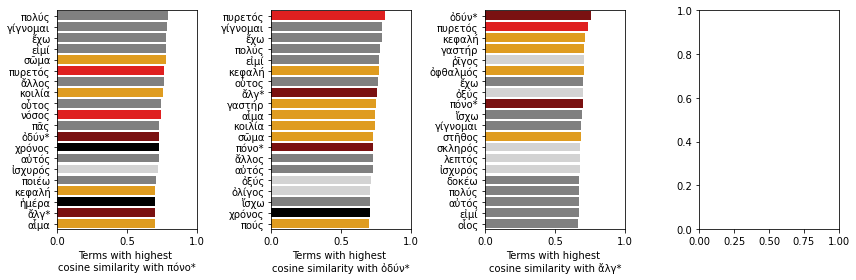

In [1262]:
#plt.rcParams['figure.figsize'] = [12, 4]
fig, axs = plt.subplots(1, 4, figsize=[12,4], tight_layout=True)

for word, ax in zip(key_words, axs):
    xcol = pmi_svd_cos_pain_df[word + " cos.sim."]
    ycol = pmi_svd_cos_pain_df[word + " word"]
    actual_colors = [terms_by_col_dict[word] for word in ycol]
    sns.barplot(x=xcol, y=ycol, palette=actual_colors, ax=ax)
    ax.set(ylabel="", xlabel="Terms with highest \ncosine similarity with " + word)
    ax.set_xticks([0, 0.5, 1])
    ax.set_xlim(0, 1)
plt.subplots_adjust(hspace=0.08) # top=1, bottom=0, left=0, right=1, hspace=0.08, wspace=1.2)

markers = [plt.Line2D([0,0],[0,0],color=color, marker="s", linestyle="") for color in colors]
plt.legend(markers, cat_colors_dict.keys(), numpoints=1,  title="Term categories", bbox_to_anchor=(1, 1), loc='upper left')

#plt.title("Terms with highest cosine similarity with the pain words ($PPMI^3$ based vectors)", loc="right")

In [1034]:
sddk.write_file("public_data/PIA/pmmi3_svd.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/pmmi3_svd.png"


In [1263]:
morpheus_by_lemma["ἐγγίγνομαι"]

[{'d': 9374, 'l': 'ἐγγίγνομαι', 's': 'to be born', 'a': None}]

In [884]:
# set_with_dataframe(PIA_overview.add_worksheet("pmi_svd_cos_pain", 1, 1), pmi_svd_cos_pain_df)

In [876]:
words = []
for col in pmi_svd_cos_pain_df.columns:
    if "word" in col:
        words.extend(pmi_svd_cos_pain_df[col].tolist())
words_unique = list(set(words))
print(len(words_unique))
print(words_unique)

52
['οὗτος', 'ἄλγ*', 'ἀποκρίνω', 'αὐτός', 'δοκέω', 'ἡμέρα', 'ἰσχυρός', 'Κοίλη', 'πυρετός', 'βληχρός', 'χρόνος', 'πᾶς', 'ἐπάγω', 'ῥῖγος', 'σπλάγχνον', 'κοιλία', 'οἷος', 'εἰμί', 'κεφαλή', 'πόνο*', 'ἐξέρχομαι', 'οὐρέει', 'ἄλλος', 'πότος', 'ὁποῖος', 'συμβαίνω', 'ἐπιλαμβάνω', 'ὀσφῦς', 'μέγας', 'ἴσχω', 'σκληρός', 'αἷμα', 'χροιά', 'ὀξύς', 'ὑγιαίνω', 'ὀφθαλμός', 'ὁράω', 'ὀλίγος', 'ὅρος', 'νόσος', 'γαστήρ', 'γονή', 'λεπτός', 'πρόσωπον', 'ψαύω', 'γίγνομαι', 'σῶμα', 'πολύς', 'ὀδύν*', 'ἔχω', 'φανερός', 'ἐρωτάω']


In [879]:
terms_by_cat_df = get_as_dataframe(PIA_overview.worksheet("terms_by_cat"))
terms_by_cat_dict = dict(zip(terms_by_cat_df["term"], terms_by_cat_df["term_category"]))
coded_words = list(terms_by_cat_dict.keys())
print(coded_words)

['πρότερος', 'ψυχρός', 'λαμβάνω', 'κεφαλή', 'ἰσχυρός', 'ἄνθρωπος', 'χολή', 'ὁπόσος', 'ἄλγ*', 'τρίτος', 'πᾶς', 'πλείων', 'σάρξ', 'συμβαίνω', 'θερμός', 'μαλλός', 'ἡμέρα', 'πόνο*', 'ὀδύν*', 'κοιλία', 'εἶμι', 'ποιέω', 'γίγνομαι', 'ἔχω', 'καθίημι', 'δοκέω', 'δίδωμι', 'ὀξύς', 'πολύς', 'μήτρα', 'ἰξύς', 'κενεών', 'χρόνος', 'σιτίον', 'ἴσχω', 'ἐσθίω', 'νόσος', 'σῶμα', 'ὀσφύς', 'ὀλίγος', 'παύω', 'γαστήρ', 'αἷμα', 'πυρετός', 'ὀφθαλμός', 'οὗτος', 'ἄλλος', 'αὐτός', 'εἰμί', 'λύπ*', 'ὀσφῦς', 'παρέχω', 'οὐδείς', 'προσήκω', 'πλευροῦ', 'τράχηλος', 'ῥῖγος', 'ἐξέρχομαι', 'βήξ', 'σῖτος', 'στῆθος', 'μεμιγμένα', 'ἀειδής', 'νειαίρην', 'ἐπίνοσον']


In [882]:
words_uncoded = [word for word in words_unique if word not in coded_words]
words_uncoded

['ἀποκρίνω',
 'Κοίλη',
 'βληχρός',
 'ἐπάγω',
 'σπλάγχνον',
 'οἷος',
 'οὐρέει',
 'πότος',
 'ὁποῖος',
 'ἐπιλαμβάνω',
 'μέγας',
 'σκληρός',
 'χροιά',
 'ὑγιαίνω',
 'ὁράω',
 'ὅρος',
 'γονή',
 'λεπτός',
 'πρόσωπον',
 'ψαύω',
 'φανερός',
 'ἐρωτάω']

In [883]:
set_with_dataframe(PIA_overview.add_worksheet("words_tmp", 1, 1), pd.DataFrame(words_uncoded))

# PMI SVD cos plotting distances

In [1098]:
pmi_svd_cos

,εἰμί,γίγνομαι,οὗτος,πολύς,ἔχω,ἄλλος,σῶμα,ποιέω,χρή,αὐτός,...,ἑβδομαῖα,ἐσόμενα,ἐναντιόομαι,ἐκπυήσει,ἄραδον,ἄπεπτον,ἁλυκὰ,ἀποξηραίνειν,ἀντέχω,ἀμαυρός
εἰμί,1.00000,0.96892,0.96484,0.96653,0.95287,0.91034,0.86949,0.86939,0.83357,0.87382,...,0.18498,0.19301,0.22417,0.16827,0.23719,0.18115,0.22748,0.24564,0.21784,0.20335
γίγνομαι,0.96892,1.00000,0.93837,0.95615,0.93507,0.89179,0.87365,0.84036,0.79994,0.85748,...,0.20088,0.19060,0.20342,0.17912,0.24124,0.17458,0.25891,0.23186,0.23155,0.19837
οὗτος,0.96484,0.93837,1.00000,0.94529,0.92556,0.89962,0.83607,0.86553,0.82259,0.85794,...,0.21245,0.21435,0.24274,0.21321,0.22194,0.17818,0.22489,0.26526,0.21810,0.18566
πολύς,0.96653,0.95615,0.94529,1.00000,0.92904,0.89546,0.85769,0.84560,0.80525,0.86459,...,0.19805,0.18372,0.22581,0.18500,0.25443,0.17898,0.24070,0.25613,0.26202,0.20045
ἔχω,0.95287,0.93507,0.92556,0.92904,1.00000,0.88890,0.85612,0.83930,0.83079,0.86131,...,0.19174,0.18306,0.20701,0.18149,0.25657,0.18691,0.26962,0.24299,0.26333,0.20151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ἄπεπτον,0.18115,0.17458,0.17818,0.17898,0.18691,0.17169,0.19739,0.20703,0.20079,0.17500,...,0.16195,0.16322,0.19676,0.06166,0.32946,1.00000,0.25261,0.22134,0.14137,0.18017
ἁλυκὰ,0.22748,0.25891,0.22489,0.24070,0.26962,0.23243,0.25040,0.24978,0.22847,0.23586,...,0.04683,0.16128,0.07393,0.06676,0.15268,0.25261,1.00000,0.18270,0.23023,0.09731
ἀποξηραίνειν,0.24564,0.23186,0.26526,0.25613,0.24299,0.27194,0.26501,0.26548,0.29376,0.25834,...,0.19335,0.25082,0.37434,0.17878,0.24981,0.22134,0.18270,1.00000,0.22073,0.16111
ἀντέχω,0.21784,0.23155,0.21810,0.26202,0.26333,0.24379,0.23743,0.23644,0.27541,0.24879,...,0.19879,0.18427,0.14131,0.29780,0.27720,0.14137,0.23023,0.22073,1.00000,0.17732


In [1105]:
# inverse similarity to distance
pmi_svd_cos_dist = (1 - pmi_svd_cos) / 1
pmi_svd_cos_dist

,εἰμί,γίγνομαι,οὗτος,πολύς,ἔχω,ἄλλος,σῶμα,ποιέω,χρή,αὐτός,...,ἑβδομαῖα,ἐσόμενα,ἐναντιόομαι,ἐκπυήσει,ἄραδον,ἄπεπτον,ἁλυκὰ,ἀποξηραίνειν,ἀντέχω,ἀμαυρός
εἰμί,0.00000,0.03108,0.03516,0.03347,0.04713,0.08966,0.13051,0.13061,0.16643,0.12618,...,0.81502,0.80699,0.77583,0.83173,0.76281,0.81885,0.77252,0.75436,0.78216,0.79665
γίγνομαι,0.03108,0.00000,0.06163,0.04385,0.06493,0.10821,0.12635,0.15964,0.20006,0.14252,...,0.79912,0.80940,0.79658,0.82088,0.75876,0.82542,0.74109,0.76814,0.76845,0.80163
οὗτος,0.03516,0.06163,0.00000,0.05471,0.07444,0.10038,0.16393,0.13447,0.17741,0.14206,...,0.78755,0.78565,0.75726,0.78679,0.77806,0.82182,0.77511,0.73474,0.78190,0.81434
πολύς,0.03347,0.04385,0.05471,0.00000,0.07096,0.10454,0.14231,0.15440,0.19475,0.13541,...,0.80195,0.81628,0.77419,0.81500,0.74557,0.82102,0.75930,0.74387,0.73798,0.79955
ἔχω,0.04713,0.06493,0.07444,0.07096,0.00000,0.11110,0.14388,0.16070,0.16921,0.13869,...,0.80826,0.81694,0.79299,0.81851,0.74343,0.81309,0.73038,0.75701,0.73667,0.79849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ἄπεπτον,0.81885,0.82542,0.82182,0.82102,0.81309,0.82831,0.80261,0.79297,0.79921,0.82500,...,0.83805,0.83678,0.80324,0.93834,0.67054,0.00000,0.74739,0.77866,0.85863,0.81983
ἁλυκὰ,0.77252,0.74109,0.77511,0.75930,0.73038,0.76757,0.74960,0.75022,0.77153,0.76414,...,0.95317,0.83872,0.92607,0.93324,0.84732,0.74739,0.00000,0.81730,0.76977,0.90269
ἀποξηραίνειν,0.75436,0.76814,0.73474,0.74387,0.75701,0.72806,0.73499,0.73452,0.70624,0.74166,...,0.80665,0.74918,0.62566,0.82122,0.75019,0.77866,0.81730,0.00000,0.77927,0.83889
ἀντέχω,0.78216,0.76845,0.78190,0.73798,0.73667,0.75621,0.76257,0.76356,0.72459,0.75121,...,0.80121,0.81573,0.85869,0.70220,0.72280,0.85863,0.76977,0.77927,0.00000,0.82268


In [1115]:
# tSNE to project all words into a 2-dimensional space
data = pmi_svd_cos_dist

tsne = TSNE(n_components=2, random_state=1, perplexity=10, metric='precomputed') # dissimilarity="precomputed",

pos = tsne.fit_transform(data) # project all points into space
xs, ys = pos[:, 0], pos[:, 1]

# extract minimal and maximal values
minmax = [pos[:, 0].min(), pos[:, 0].max(), pos[:, 1].min(), pos[:, 1].max()]

# normalize on scale from 0 to 1
xs = (xs - minmax[0]) / (minmax[1] - minmax[0])
ys = (ys - minmax[2]) / (minmax[3] - minmax[2])

KeyError: 'παχύς'

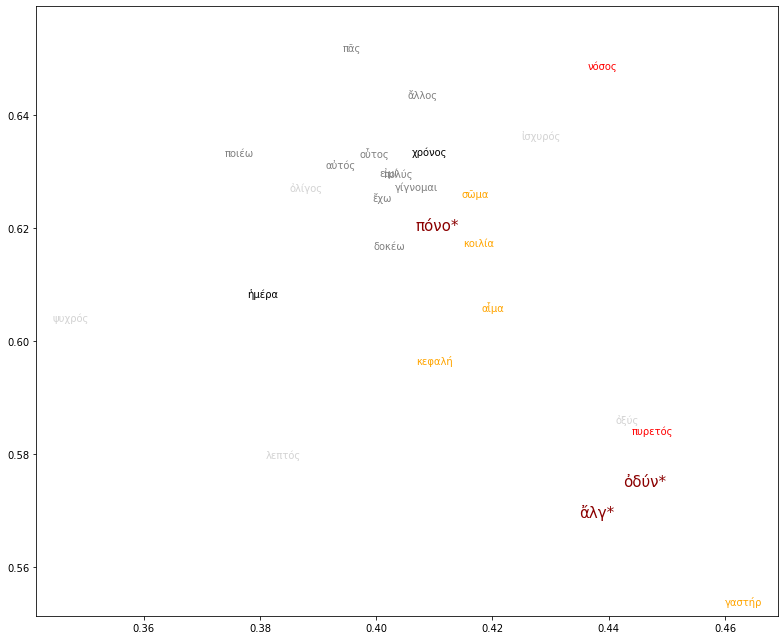

In [1133]:
fig, ax = plt.subplots(figsize=(11,9), tight_layout=True)

for x, y, word in zip(xs, ys, data.index):
    if word in unique_words:
        if word not in key_words:
            ax.scatter(x, y, color="white")# c=np.array([terms_by_col_dict[word]]))
            ax.text(x, y-0.003, word, horizontalalignment='center', fontsize=10, color=terms_by_col_dict[word])
        else:
            ax.scatter(x, y, color="white")# c=np.array([terms_by_col_dict[word]]))
            ax.text(x, y-0.003, word, horizontalalignment='center', fontsize=15, color=terms_by_col_dict[word])
    
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
#ax.set_xlim(- 0.1, 1.1)
title = "Corpus hippocraticum: tSNE of all coded terms"
ax.set_title(title)

In [ ]:
for x, y, word in zip(xs, ys, data.index):
    if word in terms_by_cat_dict.keys():
        ax.scatter(x, y, c=np.array([color]))
        ax.text(x, y + 0.01, word, horizontalalignment='center', fontsize=10)


ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_xlim(- 0.1, 1.1)
title = "Corpus hippocraticum: Document distances based on vocabulary\n(work categories by Jouanna 1999)"
ax.set_title(title)


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_values]
plt.legend(markers, color_keys, numpoints=1,  title="Work categories", fontsize=10, bbox_to_anchor=(1,1), loc="upper left")

In [1112]:
terms_by_cat_dict = dict(zip(terms_by_cat_df["term"], terms_by_cat_df["term_category"]))
terms_by_cat_dict.keys()

{'πρότερος': 'temporal quality',
 'ψυχρός': 'quality',
 'λαμβάνω': 'general term',
 'κεφαλή': 'bodily part or constituent',
 'ἰσχυρός': 'quality',
 'ἄνθρωπος': 'bodily part or constituent',
 'χολή': 'bodily part or constituent',
 'ὁπόσος': 'quality',
 'ἄλγ*': 'pain-word',
 'τρίτος': 'temporal quality',
 'πᾶς': 'general term',
 'πλείων': 'general term',
 'σάρξ': 'bodily part or constituent',
 'συμβαίνω': 'general term',
 'θερμός': 'quality',
 'μαλλός': 'general term',
 'ἡμέρα': 'temporal quality',
 'πόνο*': 'pain-word',
 'ὀδύν*': 'pain-word',
 'κοιλία': 'bodily part or constituent',
 'εἶμι': 'general term',
 'ποιέω': 'general term',
 'γίγνομαι': 'general term',
 'ἔχω': 'general term',
 'καθίημι': 'general term',
 'δοκέω': 'general term',
 'δίδωμι': 'general term',
 'ὀξύς': 'quality',
 'πολύς': 'general term',
 'μήτρα': 'bodily part or constituent',
 'ἰξύς': 'bodily part or constituent',
 'κενεών': 'bodily part or constituent',
 'χρόνος': 'temporal quality',
 'σιτίον': 'pathological stat

In [1108]:
terms_by_col_dict["γίγνομαι"]

'gray'

# Backup: Previous experiments with LSA

In [892]:
svd = TruncatedSVD(n_components=250)
lsa = svd.fit_transform(tfidf)
lsa_doc = pd.DataFrame(lsa) #, columns=vocabulary)
lsa_doc

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.291092,0.120812,-0.011414,-0.045221,0.087048,-0.015248,0.134973,0.037312,0.040419,-0.008096,...,-0.023577,0.023873,0.017753,-0.026195,0.012706,0.029686,-0.015625,-0.034971,-0.007640,-0.007286
1,0.113945,-0.048341,0.013215,-0.068549,0.199092,0.277817,0.038364,-0.080837,-0.007310,-0.050582,...,0.005202,0.005137,0.004956,0.000223,0.006238,-0.005648,-0.003812,-0.004576,0.005733,-0.003043
2,0.278826,0.343216,-0.054982,-0.059967,-0.113581,0.003020,0.013958,0.001845,0.020055,-0.038230,...,-0.006006,-0.028921,-0.005711,0.055508,0.012969,-0.002231,-0.004746,-0.062788,0.018479,-0.036495
3,0.178850,-0.017742,0.019273,-0.042593,0.297982,-0.070750,0.074128,-0.163608,-0.043452,-0.087134,...,-0.053331,-0.026377,-0.021582,-0.020280,-0.024655,-0.033270,0.029185,0.019736,-0.016080,0.044814
4,0.066580,-0.000201,-0.002682,0.012326,0.013823,-0.011123,0.012705,0.024484,0.029276,-0.004064,...,-0.000818,0.008670,-0.014765,-0.025303,-0.008954,0.000089,0.012837,-0.018779,0.017352,-0.015500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24451,0.075155,-0.018564,-0.005475,0.073267,0.005832,-0.018919,0.031640,-0.021884,0.068928,-0.067545,...,0.002607,-0.001323,0.003396,0.002406,0.003437,0.003704,0.000441,0.001182,0.002269,-0.001387
24452,0.296445,0.058825,-0.050300,0.135022,0.033343,0.169435,0.042056,0.001736,0.115289,-0.071581,...,-0.002363,0.007474,0.010698,-0.012415,0.003211,0.005329,0.006494,0.007056,-0.009217,-0.000316
24453,0.065155,0.040187,0.399040,0.056255,-0.012848,-0.014455,0.004877,-0.012601,0.004090,-0.011182,...,-0.016274,0.000194,-0.001512,-0.031107,-0.004968,-0.036236,0.006979,-0.010521,-0.037103,-0.038958
24454,0.158804,0.026910,-0.011339,-0.081714,-0.097286,-0.011491,-0.005095,-0.019178,0.002196,-0.016735,...,-0.005564,0.018009,0.014392,0.023937,0.042614,-0.010459,-0.002001,-0.021583,0.007948,0.015325


In [893]:
lsa_word = pd.DataFrame(svd.components_, columns=vocabulary).T #, columns=vocabulary)
lsa_word

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
εἰμί,0.481994,0.757178,-0.126295,-0.137315,-0.309753,0.076535,-0.036132,-0.094879,-0.061312,-0.068219,...,0.000771,-0.004147,-0.002766,0.005831,0.001313,0.001150,-0.002089,0.001149,-0.002744,0.000613
γίγνομαι,0.385735,-0.563874,0.033859,-0.456447,-0.465803,-0.095518,-0.077631,-0.051129,-0.078033,-0.144964,...,-0.001372,-0.001277,-0.008644,0.005807,-0.002493,-0.005655,0.002305,-0.002098,-0.001804,0.000854
οὗτος,0.386984,-0.237714,-0.155228,0.810529,-0.182356,0.086513,0.034810,-0.142527,-0.120311,0.049164,...,-0.006240,0.000887,-0.001492,0.000447,-0.000935,-0.000493,-0.002332,-0.004415,-0.004133,0.001817
πολύς,0.285897,-0.126532,0.034322,-0.172830,0.507344,0.706528,0.095685,-0.206553,-0.021490,-0.126551,...,0.002339,0.002850,-0.002082,0.001739,0.004876,-0.000140,0.003147,0.004958,0.005255,-0.001397
ἔχω,0.207923,-0.000684,-0.004842,0.029985,0.466058,-0.461504,-0.606931,-0.298151,-0.038327,-0.152027,...,-0.001579,0.001877,-0.003560,0.002272,-0.001240,0.000518,-0.001716,0.001732,0.003596,0.002983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ἀποστέλλω,0.000777,0.000133,-0.000011,0.000077,0.000478,-0.000402,0.000665,0.001117,0.002575,0.000311,...,0.000616,0.000805,-0.000060,0.000608,0.001988,0.000368,-0.002334,0.000241,-0.000358,0.000262
ἀποπέτομαι,0.000847,-0.000470,0.000101,-0.000828,0.000885,0.000547,-0.000191,0.000175,0.000523,0.002245,...,0.000160,0.001253,-0.001956,0.000276,-0.001185,0.000101,0.001000,-0.001763,-0.000187,-0.003585
ἀναΐσσει,0.000931,-0.000348,-0.000052,-0.000276,0.000590,-0.000395,-0.000286,-0.000444,0.000062,0.000790,...,-0.000180,0.002646,0.002093,0.000561,-0.000915,0.002104,-0.000686,-0.000118,-0.003367,0.000138
ἀλφίτοισι,0.000256,-0.000042,-0.000006,0.000152,0.000426,-0.000134,-0.000013,0.001373,-0.001122,-0.000171,...,-0.006492,-0.001816,0.000753,-0.000192,0.000098,0.000079,0.002321,-0.000988,-0.002716,0.004547


In [894]:
lsa_word_cos = pd.DataFrame(cosine_similarity(lsa_word.to_numpy()).round(5), columns=vocabulary, index=vocabulary)
lsa_word_cos

,εἰμί,γίγνομαι,οὗτος,πολύς,ἔχω,ἄλλος,σῶμα,ποιέω,χρή,αὐτός,...,ἀσθενείη,ἀπύρετος,ἀπόπατος,ἀπωθέω,ἀποτελευτάω,ἀποστέλλω,ἀποπέτομαι,ἀναΐσσει,ἀλφίτοισι,ἀλέα
εἰμί,1.00000,-0.00104,-0.00017,-0.00001,-0.00038,-0.00007,-0.00040,-0.00047,-0.00001,-0.00024,...,-0.01677,0.12176,-0.00279,-0.01038,-0.00766,-0.02031,-0.00872,-0.00344,-0.00716,-0.00451
γίγνομαι,-0.00104,1.00000,0.00009,-0.00037,-0.00082,-0.00029,0.00015,-0.00067,-0.00011,-0.00033,...,0.01665,-0.00345,0.06058,-0.00745,-0.00191,-0.00493,0.00815,0.01265,-0.00159,0.01221
οὗτος,-0.00017,0.00009,1.00000,-0.00015,0.00010,-0.00011,-0.00036,0.00030,0.00013,-0.00041,...,0.05083,-0.01183,0.05480,-0.00279,-0.00102,-0.02526,-0.01083,0.01191,0.00364,-0.02468
πολύς,-0.00001,-0.00037,-0.00015,1.00000,-0.00006,-0.00025,0.00008,-0.00024,0.00030,-0.00023,...,-0.02689,0.00808,-0.01440,-0.00393,-0.02168,-0.00753,0.01969,0.01149,-0.00295,0.05481
ἔχω,-0.00038,-0.00082,0.00010,-0.00006,1.00000,-0.00016,-0.00014,-0.00026,0.00014,-0.00011,...,0.02605,-0.02282,-0.01585,-0.00636,-0.01980,-0.01552,-0.00505,0.02694,-0.00575,-0.00837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ἀποστέλλω,-0.02031,-0.00493,-0.02526,-0.00753,-0.01552,-0.01677,0.10073,0.10660,-0.00582,-0.03260,...,0.04649,-0.05125,-0.03915,-0.01910,-0.01652,1.00000,0.03234,0.02619,-0.07021,-0.02607
ἀποπέτομαι,-0.00872,0.00815,-0.01083,0.01969,-0.00505,-0.01221,0.05677,-0.01239,-0.00451,0.02542,...,0.02873,-0.06885,0.03287,-0.03588,0.17936,0.03234,1.00000,-0.02274,-0.04724,-0.03297
ἀναΐσσει,-0.00344,0.01265,0.01191,0.01149,0.02694,0.01458,0.01206,-0.01116,-0.01048,0.02127,...,0.01167,-0.09959,-0.07131,-0.00159,0.07013,0.02619,-0.02274,1.00000,0.00697,-0.05355
ἀλφίτοισι,-0.00716,-0.00159,0.00364,-0.00295,-0.00575,-0.00255,-0.00138,-0.01112,-0.00518,-0.00910,...,-0.07956,0.05779,-0.04862,-0.03991,-0.00792,-0.07021,-0.04724,0.00697,1.00000,0.03752


In [895]:
lsa_word_cos.sort_values("αἰτία", ascending=False)["αἰτία"][1:11]

ἐπιφέρω        0.39020
ἄδηλος         0.39018
αἴτιος         0.38436
ἀπόκρισις      0.38083
ὅδε            0.37467
πάθος          0.36896
θεός           0.35816
προειρημένα    0.34045
ἔργον          0.32858
καλός          0.32827
Name: αἰτία, dtype: float64

In [896]:
lsa_word_cos.sort_values("ὀδύν*", ascending=False)["ὀδύν*"][1:11]

ἀπαλλάσσηται    0.44013
χλιαίνειν       0.43666
πλευρίτιδι      0.42847
ὀξείη           0.37870
βρέγμα          0.33909
πλευροῦ         0.33297
νάρκη           0.30313
χλιάσματα       0.26793
φοιτάω          0.25847
ἄχθομαι         0.25395
Name: ὀδύν*, dtype: float64

In [897]:
lsa_word_cos.sort_values("πόνο*", ascending=False)["πόνο*"][1:11]

δύσπνοια       0.30235
ἀποπέτομαι     0.26514
γυμνάζω        0.21987
περισσῇσιν     0.21487
κουφίζω        0.21327
ὑποχονδρίῳ     0.20942
εἴλω           0.20890
ἀποτελευτάω    0.20226
σύμμετρος      0.19750
ἀφωνίαι        0.19118
Name: πόνο*, dtype: float64

In [898]:
def get_most_similar(model_df, target_term, number):
    all_similar = []
    for term in model_df.columns:
        similarity = (term, cosine_similarity([model_df[target_term],  model_df[term]])[0][1])
        all_similar.append(similarity)
    return sorted(all_similar, key=lambda number: number[1], reverse=True)[1:number]

In [899]:
key_words = ['λύπ*', 'ἄλγ*', 'ὀδύν*', 'πόνο*']

In [900]:
for word in key_words:
    if word in lsa_word_cos.index:
        print(word)

λύπ*
ἄλγ*
ὀδύν*
πόνο*
